## Prepare text

In [2]:
# typical libraries...
import numpy as np
import matplotlib.pyplot as plt

# for importing and working with texts
import requests
import re
import string

# adjust matplotlib defaults to personal preferences
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [6]:
# get raw text from internet
text = requests.get('https://www.gutenberg.org/files/35/35-0.txt').text

# character strings to replace with space
strings2replace = [ '\r\n\r\nâ\x80\x9c','â\x80\x9c','â\x80\x9d','\r\n','â\x80\x94','â\x80\x99','â\x80\x98','_', ]

# use regular expression (re) to replace those strings with space
for str2match in strings2replace:
  text = re.compile(r'%s'%str2match).sub(' ', text)

# remove non-ASCII characters and numbers, and make lower-case
text = re.sub(r'[^\x00-\x7F]+', ' ', text)
text = re.sub(r'\d+','',text).lower()

In [7]:
# split into words that contain >1 character
words = re.split(fr'[{string.punctuation}\s]+',text)
words = [item.strip() for item in words if item.strip()]
words = [word for word in words if len(word)>1]

# create the vocab / lexicon
vocab = sorted(set(words))
nWords = len(words)
nLex = len(vocab)


In [8]:
# create the encoder/decoding mapping dictionaries
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for i,w in enumerate(vocab)}

In [9]:
# create encoder and decoder functions
def encoder(words,encode_dict):

  # loop through the words and find their token in the vocab
  idxs = np.zeros(len(words),dtype=int)
  for i,w in enumerate(words):
    idxs[i] = encode_dict[w]
  return idxs

# and the decoder function
def decoder(idxs,decode_dict):
  return ' '.join([decode_dict[i] for i in idxs])

## 2. A random walk through the Time Machine

In [10]:
# random tokens
randomTokens = np.random.randint(0, len(vocab), 10)

# test with random token indices
print(f'Random tokens: \n\t{randomTokens}\n')
print(f'Decoded text: \n\t{decoder(randomTokens, idx2word)}')

Random tokens: 
	[2018 3488 3993 2812 1416 4473 2364  871  137  717]

Decoded text: 
	immemorial sepulture takes own fancied whirled lit cultivate and commerce


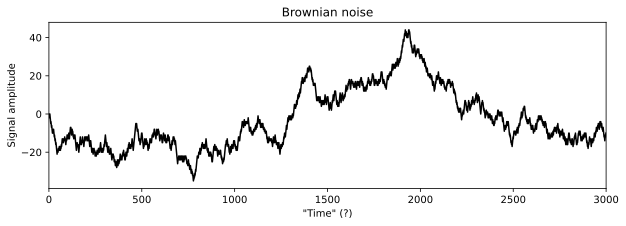

In [11]:
# A brief aside on Brownian noise
brownNoise = np.cumsum(np.random.choice([-1,1],3000))

plt.figure(figsize=(10,3))
plt.plot(brownNoise,'k')
plt.gca().set(xlim=[0,len(brownNoise)],xlabel='"Time" (?)',ylabel='Signal amplitude',title='Brownian noise')
plt.show()

In [12]:
# Brownian noise
brownNoise = np.cumsum(np.random.choice([-1,1],30))
print(brownNoise)

BrownianRandomTokens = brownNoise + np.random.choice(nLex,1)
print(BrownianRandomTokens)
print('')

# test with random token indices
print(f'Brownian random tokens: \n\t{BrownianRandomTokens}\n')
print(f'Decoded text: \n\t{decoder(BrownianRandomTokens,idx2word)}')

[1 2 3 2 3 2 1 2 1 2 1 2 1 2 3 4 5 4 3 2 1 2 1 2 1 0 1 2 1 0]
[1993 1994 1995 1994 1995 1994 1993 1994 1993 1994 1993 1994 1993 1994
 1995 1996 1997 1996 1995 1994 1993 1994 1993 1994 1993 1992 1993 1994
 1993 1992]

Brownian random tokens: 
	[1993 1994 1995 1994 1995 1994 1993 1994 1993 1994 1993 1994 1993 1994
 1995 1996 1997 1996 1995 1994 1993 1994 1993 1994 1993 1992 1993 1994
 1993 1992]

Decoded text: 
	hypertrophied hypothesis hysterical hypothesis hysterical hypothesis hypertrophied hypothesis hypertrophied hypothesis hypertrophied hypothesis hypertrophied hypothesis hysterical ice ichthyosaurus ice hysterical hypothesis hypertrophied hypothesis hypertrophied hypothesis hypertrophied husk hypertrophied hypothesis hypertrophied husk


## 3. Distribution of word lengths

In [13]:
# loop through the words and count the characters per word
numChars = np.zeros(nWords,dtype=int)
for i,w in enumerate(words):
  numChars[i] = len(w)

# now count the number of words with those characters
charCounts = np.zeros(np.max(numChars)+1, dtype=int)
for i in range(len(charCounts)):
  charCounts[i] = np.sum(numChars==i)


# and plot
_,axs = plt.subplots(2,1,figsize=(10,7))
axs[0].scatter(range(nWords),numChars,marker='.',s=10,c=np.linspace(.1,.9,len(numChars)),alpha=.4)
axs[0].set(yticks=range(1,int(np.max(numChars))),xlabel='Token index',xlim=[-15,nWords+15],
           ylabel='Number of characters',title='Character count by token index')

axs[1].bar(range(len(charCounts)),charCounts,edgecolor='k',color=[.9,.7,.9])
axs[1].set(xticks=range(1,len(charCounts)),xlim=[0,len(charCounts)],xlabel='Number of characters',
           ylabel='Token count',title='Histogram of character count frequencies')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 4. Encode a Novel sentence

In [14]:
# the text to decode
sentence = 'The space aliens came to Earth to steal watermelons and staplers.'

# preprocess (remove punctuation, make lower-case, split into words)
words_new = re.split(fr'[,.\s]+',sentence.lower())

# remove empty items
words_new = [item.strip() for item in words_new if item.strip()]
words_new

['the',
 'space',
 'aliens',
 'came',
 'to',
 'earth',
 'to',
 'steal',
 'watermelons',
 'and',
 'staplers']

In [ ]:
# tokenize (uh oh...)
encoder(words_new,word2idx)

In [17]:
# Process <|unk|>
# need to update the vocab
word2idx_new = word2idx.copy()
idx2word_new = idx2word.copy()

# add an entry for unknown words
word2idx_new['<|unk|>'] = len(word2idx)+1
idx2word_new[len(idx2word)+1] = '<|unk|>'

In [18]:
# need a new encoder function
def encoder_new(words,encode_dict):

  # initialize a vector of numerical indices
  idxs = np.zeros(len(words),dtype=int)

  # loop through the words and find their token in the vocab
  for i,w in enumerate(words):
    if w in encode_dict:
      idxs[i] = encode_dict[w]
    else:
      idxs[i] = encode_dict['<|unk|>']

  # return the results!
  return idxs

In [19]:
# try again
tokenidx = encoder_new(words_new,word2idx_new)
tokenidx

array([4042, 3734, 4590,  519, 4119, 1191, 4119, 4590, 4590,  137, 4590])

In [20]:
# need a new decoder function?
decoder(tokenidx,idx2word_new)

'the space <|unk|> came to earth to <|unk|> <|unk|> and <|unk|>'